<a href="https://colab.research.google.com/github/landofgiurla/ML-zoomcamp/blob/main/Iris_project_k_means_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

1.   Load the Iris data set
2.   Pre-analysis of the set using the provided labels
3.   Implementing k-means - intro
4.   Implementing k-means - functions
5.   Compute the 3 clusters
3.   Scatter plot of the 3 clusters with centroids to visualize the distribution of labels in each of the clusters








#Initial visualization of the data set
The set has 150 data points and 4 features for each datapoint (so 4 columns and 150 rows). Observations:
1. `iris_features` contains a numpy array of 4 attributes for 150 different plants (shape 150 x 4).
2. `iris_target` contains the class of each plant, i.e. the TYPE of plant that it is (in this case there are 3 possible classes). There are 3 classes of plants in the dataset: *Iris-Setosa*, *Iris-Versicolour*, and *Iris-Virginica*. The class names will be stored in `iris_target_names`.
3. iris_feature_names will be a list of 4 names, one for each attribute in `iris_features`.

It is a 4-dimensional data set e the first thing we want to do is to visualize it. being a 4-dimeensional data set, in order to visualise it, we can resort to cross sectional 2-D scatter plots (1 scatter plot for every combination of features, i.e. 6 scatter plots).

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
iris_data = load_iris() # Loading the dataset

In [23]:
iris_features = iris_data['data']
iris_target = iris_data['target']
iris_feature_names = iris_data['feature_names']
iris_target_names = iris_data['target_names']

# # Convert iris_target to string labels instead of int labels currently (0, 1, 2) for the classes
iris_target = iris_target_names[iris_target]

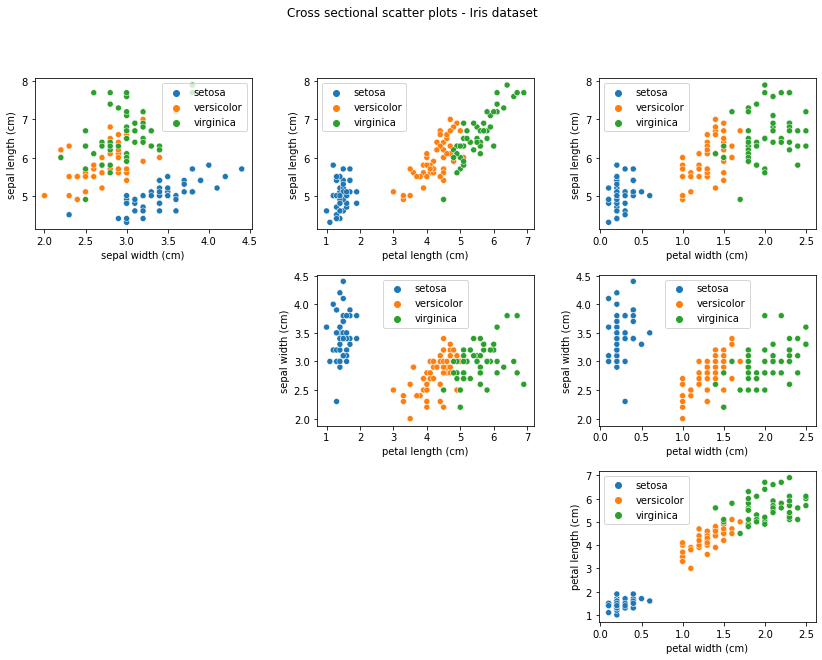

In [24]:
plt.figure(figsize=(14, 10))
plt.suptitle("Cross sectional scatter plots - Iris dataset")
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(1, 4):
    for j in range(i):
        plt.subplot(3, 3, i + 3 * j)
        sns.scatterplot(x=iris_features[:, i], y=iris_features[:, j], hue=iris_target)
        plt.xlabel(iris_feature_names[i])
        plt.ylabel(iris_feature_names[j])

# Imports

In [36]:
from pprint import pprint
from math import fsum
from typing import Tuple, Iterable, Sequence, List, Dict, DefaultDict
from collections import defaultdict
from math import sqrt
from functools import partial
from random import sample
import pandas as pd
import numpy as np
from sklearn import datasets
Point = Tuple [int, ...]
Centroid = Point

# Functions
Inspired by Big Ideas and Little Code in Python by Raymond Hettinger.

## Accurate Arithmentic mean function
We need an accurate arithmetic mean capable of minimizing the rounding error. We use `fsum()` to eliminate the rounding error. In the function we are looping over the data and we use `len()` so we need to pass on a sequence, that's why we first of all convert the data into a list. For type hinting purposes, the requirement is for the data to be an iterable of floats and the final outcome has to be a `float`.

In [26]:
def mean(data: Iterable[float]) -> float:
    'Accurate arithmetic mean'
    data = list(data)
    return fsum(data)/len(data)

## Euclidian distance function
The function computes the Euclidian distance between 2 points. We can't use the `hypot()` function from the `math` module because it only works in 2 dimensions. The distance (hypotenuse) between 2 points can be calculated as the squared root of the sum of the squares. Using the coordinates of 2 points we need to loop over all the coordinates of the 2 points, so we can `zip()` them together and then we take the `fsum` of square of the differences (to deal with negatives) and then the squared root of the result. The distance is expressed with a `float`. We also localize the function to improve efficiency by adding local arguments to it. Annotations for type hinting: p is a point (a tuple of integers). We create an alias `Point` (see imports section) which refers to a tuple of integers (the coordinates of that point). The argument to `dist()` is 2 points and the output is a floating point number.

In [27]:
def dist(p: Point, q: Point, sqrt=sqrt, fsum=fsum, zip=zip) -> float:
    'Multi-dimensional euclidean distance'
    return sqrt(fsum((x1 - x2) ** 2.0 for x1, x2 in zip(p, q)))

## Function to assign the points to centroids
Given a 'centroid' (the middle of set of points, the potential center of a cluster), we need to assign each point to the closest centroid. Given some data, we loop over them and assign them to a centroid. For this grouping operation, we use `defaultdict()` applied to a `list()` rather than a `set()` so that we keep duplicates. In constructing the function, we use `partial()` that freezes the first argument of a function. This is useful in this case because the distance is always computed from the same, fixed point. The function returns a dict(), whose keys are the centroid and whose values are the points "orbiting" around that particula centroid. 

In [28]:
def assign_data(centroids: Sequence[Centroid], data: Iterable[Point]) -> Dict[Centroid, Sequence[Point]]:
    'Group the datapoints to the closest centroid'
    d = defaultdict(list)
    for point in data:
        closest_centroid = min(centroids, key = partial(dist, point))
        d[closest_centroid].append(point)
    return dict(d)

## Function to compute the centroids
We have groups of points and we need to collapse each group in order to calculate the average of the points that are inside it. In order to achieve this, we take the average of each and everyone of the coordinates (each point has 4 coordinates). We can achieve that by using the `zip(*)` function that transposes the group bringing all the x coordinates, the y coordinates, the z coordinates together and the u coordinates. We use the `map()` function to find the average of the new groups. And finally we transform the average into a tuple and we call this resulting tuple the center of that particular group. We apply the same technique to all the groups to find the center of each group via a list comprehnsion. For clarity, we extract the `list(zip(*data))` expression and we call it `transpose()`. The resulting centroids are expressed via a list.

In [29]:
def transpose(data):
    'Swap the rows and column in a 2-D array of data'
    return list(zip(*data))


In [30]:
def compute_centroids(groups: Iterable[Sequence[Point]])-> List[Centroid]:
    'Compute the centroid of each group'
    return [tuple(list(map(mean,transpose(group)))) for group in groups]

## k-means function
We want to label the data into a specific number (k) of clusters. The funtions returns the centers (centroids) of the groups of data. In order to achieve this result, first of all, we want to make sure that the data is *iterable* (that we can go over it multiple times). The technique for that is the same used in the `mean()` function: we take the data and turn them into a list. We then compute the 2 initial, *random*, centroids. These centroids are random but they can't be the same so we need to use the `sample()` function from the `random` module to take samples without replacements. After that, we need to assign the data (this is the labelling phase, each data gets labelled according to which centroid it orbitates around).

Once the initial centroid are computed, we go on computing new centroids. The new centroids are no lonnger nased on the original 2, they are based on the data assigned to the original 2 centroids. We take all the points, we average them and then we find the new centers. For that, we use the `compute_centroids()` function and its arguments are all of the groups of data. In the loop, `labeled` is a dictionary that has centroids as `keys` and points as `values`. We then extraxt the values and compute the new centroids, in a iterative way, by repeating this operations a number of times. We set the number of iterations to 50 for the iteration to ba able to converge. The outcome is a list of k-means centroids.

In [31]:
def k_means(data: Iterable[Point], k: int = 2, iterations: int = 50) -> List[Centroid] :
    data = list(data)
    centroids = sample(data, k)
    for i in range(iterations):
        labeled = assign_data(centroids, data)
        centroids = compute_centroids(labeled.values())
    return centroids

# Implementing the algorithm

In [60]:
iris = datasets.load_iris()
import_iris_data = pd.DataFrame(iris['data'])
iris_data = [tuple(x) for x in import_iris_data.values.tolist()]

In [61]:
iterations = 100
k = 3
computed_centroids = k_means(iris_data, k, iterations)

print('-------------------------------------------------COMPUTED CENTROIDS-----------------------------------------------------------------------')

pprint(computed_centroids, width=100)


print('--------------------------------------------------COMPUTED CLUSTERS-----------------------------------------------------------------------')


computed_clusters = assign_data(computed_centroids, iris_data)
pprint(computed_clusters, width=180)

-------------------------------------------------COMPUTED CENTROIDS-----------------------------------------------------------------------
[(5.006, 3.428, 1.462, 0.24600000000000002),
 (5.901612903225806, 2.7483870967741937, 4.393548387096774, 1.4338709677419357),
 (6.8500000000000005, 3.0736842105263156, 5.742105263157894, 2.0710526315789473)]
--------------------------------------------------COMPUTED CLUSTERS-----------------------------------------------------------------------
{(5.006, 3.428, 1.462, 0.24600000000000002): [(5.1, 3.5, 1.4, 0.2),
                                              (4.9, 3.0, 1.4, 0.2),
                                              (4.7, 3.2, 1.3, 0.2),
                                              (4.6, 3.1, 1.5, 0.2),
                                              (5.0, 3.6, 1.4, 0.2),
                                              (5.4, 3.9, 1.7, 0.4),
                                              (4.6, 3.4, 1.4, 0.3),
                                      

In [62]:
centroid1 = computed_centroids[0]
centroid2 = computed_centroids[1]
centroid3 = computed_centroids[2]
print('---------------------------------------------')
print(f'Centroid 1: {centroid1}')
print('---------------------------------------------')
print(f'Centroid 2: {centroid2}')
print('---------------------------------------------')
print(f'Centroid 3: {centroid3}')
print('---------------------------------------------')

cluster1 = computed_clusters.get(computed_centroids[0])
cluster2 = computed_clusters.get(computed_centroids[1])
cluster3 = computed_clusters.get(computed_centroids[2])
print('================================')
print(f'Cluster 1: {cluster1}')
print('================================')
print(f'Cluster 2: {cluster1}')
print('================================')
print(f'Cluster 3: {cluster1}')
print('================================')

---------------------------------------------
Centroid 1: (5.006, 3.428, 1.462, 0.24600000000000002)
---------------------------------------------
Centroid 2: (5.901612903225806, 2.7483870967741937, 4.393548387096774, 1.4338709677419357)
---------------------------------------------
Centroid 3: (6.8500000000000005, 3.0736842105263156, 5.742105263157894, 2.0710526315789473)
---------------------------------------------
Cluster 1: [(5.1, 3.5, 1.4, 0.2), (4.9, 3.0, 1.4, 0.2), (4.7, 3.2, 1.3, 0.2), (4.6, 3.1, 1.5, 0.2), (5.0, 3.6, 1.4, 0.2), (5.4, 3.9, 1.7, 0.4), (4.6, 3.4, 1.4, 0.3), (5.0, 3.4, 1.5, 0.2), (4.4, 2.9, 1.4, 0.2), (4.9, 3.1, 1.5, 0.1), (5.4, 3.7, 1.5, 0.2), (4.8, 3.4, 1.6, 0.2), (4.8, 3.0, 1.4, 0.1), (4.3, 3.0, 1.1, 0.1), (5.8, 4.0, 1.2, 0.2), (5.7, 4.4, 1.5, 0.4), (5.4, 3.9, 1.3, 0.4), (5.1, 3.5, 1.4, 0.3), (5.7, 3.8, 1.7, 0.3), (5.1, 3.8, 1.5, 0.3), (5.4, 3.4, 1.7, 0.2), (5.1, 3.7, 1.5, 0.4), (4.6, 3.6, 1.0, 0.2), (5.1, 3.3, 1.7, 0.5), (4.8, 3.4, 1.9, 0.2), (5.0, 3.0, 1.6, 

In [63]:
label1_array = np.asarray(['cluster1'] * len(cluster1))
label2_array = np.asarray(['cluster2'] * len(cluster2))
label3_array = np.asarray(['cluster3'] * len(cluster3))

In [64]:
cluster1_array = np.asarray(cluster1)
cluster2_array = np.asarray(cluster2)
cluster3_array = np.asarray(cluster3)

In [65]:
arr_k = np.vstack((cluster1_array, cluster2_array, cluster3_array))

In [66]:
arr_label = np.concatenate((label1_array, label2_array, label3_array))

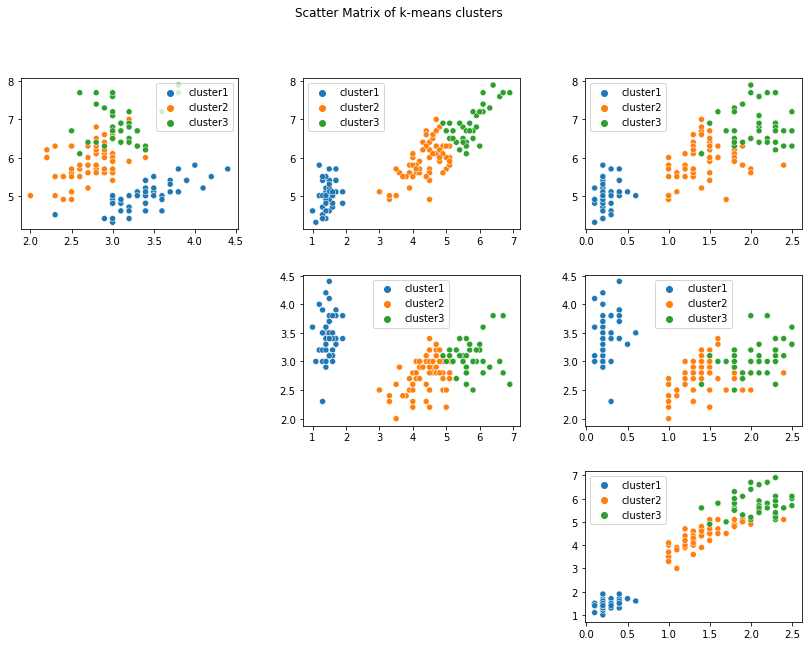

In [67]:
plt.figure(figsize=(14, 10))
plt.suptitle("Scatter Matrix of k-means clusters")
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(1, 4):
    for j in range(i):
        plt.subplot(3, 3, i + 3 * j)
        sns.scatterplot(x=arr_k[:, i], y=arr_k[:, j], hue=arr_label)